In [1]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import numpy as np

In [2]:
data = pd.read_csv('C:\\Users\\corey\\Desktop\\git\\portfolio\\data_portfolio\\realestate_ml\\data\\houston_houses.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,year built,Private Pool,zip,price
0,3.0,1758.0,7150.0,2.0,0,1.0,1978.0,False,77084,221000.0
1,4.0,2958.0,9400.0,3.0,1,2.0,1980.0,False,77070,359500.0
2,3.0,1120.0,6000.0,2.0,0,1.0,1936.0,False,77008,825000.0
3,3.0,1714.0,5500.0,2.0,0,1.0,1986.0,False,77095,289995.0
4,0.0,1470.0,4895.0,0.0,0,1.0,1977.0,False,77016,280000.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31947 entries, 0 to 31946
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      31947 non-null  float64
 1   Sqft.         31947 non-null  float64
 2   lot Sqft.     31947 non-null  float64
 3   full baths    31947 non-null  float64
 4   half baths    31947 non-null  int64  
 5   stories       31947 non-null  float64
 6   year built    31947 non-null  float64
 7   Private Pool  31947 non-null  bool   
 8   zip           31947 non-null  int64  
 9   price         31947 non-null  float64
dtypes: bool(1), float64(7), int64(2)
memory usage: 2.2 MB


In [4]:
data[['bedrooms', 'full baths', 'half baths','zip']] = data[['bedrooms', 'full baths', 'half baths','zip']].astype(str)

In [5]:
data['age'] = data.apply(lambda x: 2022 - x['year built'] + 1 if x['year built'] else 0, axis=1)
data = data.drop(['year built'], axis=1)
data.describe()

,Sqft.,lot Sqft.,stories,price,age
count,31947.000000,3.194700e+04,31947.000000,3.194700e+04,31947.000000
mean,2384.349516,1.130032e+04,1.721694,5.002466e+05,21.497198
std,1172.923698,4.506365e+04,23.930095,5.990412e+05,26.561351
min,0.000000,0.000000e+00,1.000000,1.000000e+00,0.000000
25%,1682.000000,1.660000e+03,1.000000,2.884950e+05,1.000000
50%,2184.000000,6.373000e+03,1.000000,3.752320e+05,12.000000
75%,2830.000000,8.795500e+03,2.000000,5.300000e+05,39.000000
max,36245.000000,1.441410e+06,3306.000000,2.650000e+07,1823.000000


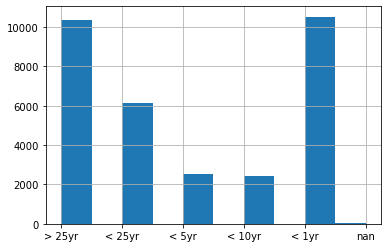

In [6]:
# The majority of homes are brand new or older than 25 years
data['age_cat'] = pd.cut(data['age'], 
                         bins=[0, 1, 5, 10, 25, np.inf], 
                         labels=['< 1yr', '< 5yr', '< 10yr', '< 25yr', '> 25yr'])
data = data.drop('age', axis=1)
data[['age_cat']] = data[['age_cat']].astype(str)
data['age_cat'].hist()
plt.show()

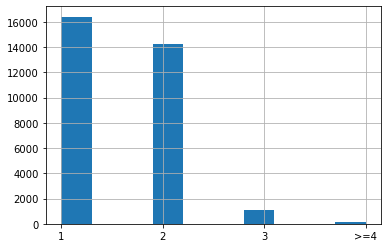

In [7]:
data['stories_cat'] = pd.cut(data['stories'], 
                         bins=[0, 1, 2, 3, np.inf], 
                         labels=['1', '2', '3', '>=4'])
data = data.drop('stories', axis=1)
data[['stories_cat']] = data[['stories_cat']].astype(str)
data['stories_cat'].hist()
plt.show()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31947 entries, 0 to 31946
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      31947 non-null  object 
 1   Sqft.         31947 non-null  float64
 2   lot Sqft.     31947 non-null  float64
 3   full baths    31947 non-null  object 
 4   half baths    31947 non-null  object 
 5   Private Pool  31947 non-null  bool   
 6   zip           31947 non-null  object 
 7   price         31947 non-null  float64
 8   age_cat       31947 non-null  object 
 9   stories_cat   31947 non-null  object 
dtypes: bool(1), float64(3), object(6)
memory usage: 2.2+ MB


In [9]:
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.columns)

Index(['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths',
       'Private Pool', 'zip', 'age_cat', 'stories_cat'],
      dtype='object')


In [10]:
cat_col = ['bedrooms', 'full baths', 'half baths', 'stories_cat', 'zip', 'Private Pool', 'age_cat']
num_col = ['Sqft.', 'lot Sqft.', 'full baths']

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_col),
        ("cat", OneHotEncoder(), cat_col),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

In [13]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                bootstrap=True,
                                n_jobs=1, 
                                random_state=42).fit(X_train_prepared, y_train)
forest.score(X_test_prepared, y_test)                                    

0.4923938412741329

In [15]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':(10, 25, 100),
              'max_depth':(None, 2, 5),
              'bootstrap':(True, False),
              'warm_start':(True, False)}
forest_reg = RandomForestRegressor(n_jobs=-1)
gs_forest = GridSearchCV(forest_reg, parameters)

gs_forest.fit(X_train_prepared, y_train)
gs_forest.get_params()

{'cv': None,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': None,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': -1,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(n_jobs=-1),
 'n_jobs': None,
 'param_grid': {'n_estimators': (10, 25, 100),
  'max_depth': (None, 2, 5),
  'bootstrap': (True, False),
  'warm_start': (True, False)},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [18]:
gs_forest.score(X_test_prepared, y_test)

0.4888042248338976